In [1]:
import keras_ocr
import pytesseract
import matplotlib.pyplot as plt

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


# Keras OCR

In [2]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
image_urls = [
    './E_15_image/M1.jpg',
    './E_15_image/M2.jpg', 
    './E_15_image/M3.jpg',
    './E_15_image/M8.jpg'

    
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

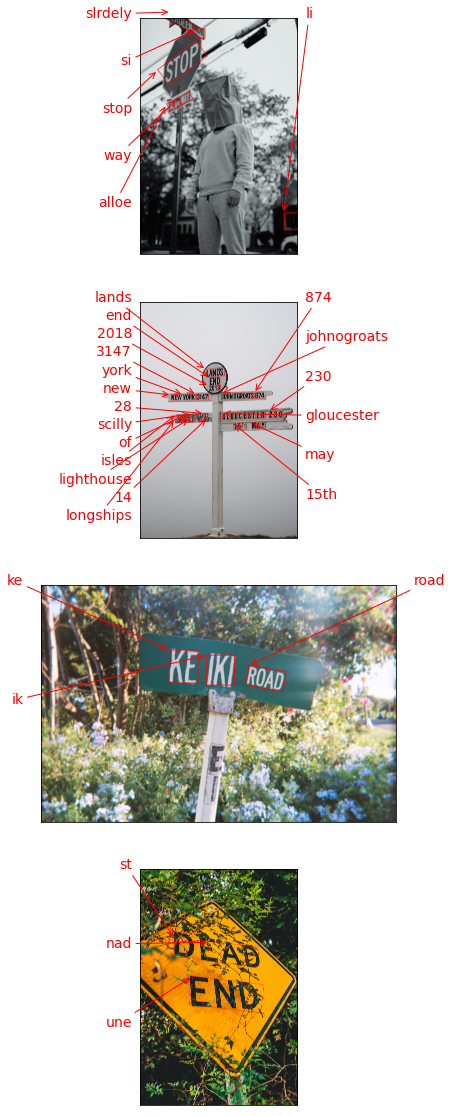

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract OCR

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./E_15_image/', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/explore//E_15_image'
img_file_path = work_dir + '/M3.jpg'   

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/explore//E_15_image/0000.png


In [6]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Done


## 회고
1. 
- 도로 표지판을 인식하여 텍스트로 출력해주는 방법을 기획.
- 도로 표지판의 경우 숫자와 문자로 지명 위치 거리 주의사항들이 적혀 있으므로 OCR을 통해 인식가능하다
- 도로를 주행하며 운전자가 놓칠수 있는 표지판들을 카메라로 입력을 받아,
- 입력받은 이미지들을 OCR을 통해 텍스트로 출력하여 놓칠 수 있는 표지판들을 뽑아내 미리기록하는 자동화시스템을 만들 수 있다.
- 이미지를 자동으로 입력받아 OCR을 적용하여 분석하여 출력하므로 훨씬 유용하다.


2.
- 주행중에 찍힌 사진은 입력값의 파라미터를 조정해 주기 어렵다.(원하는 피사계 심도나, 표지판의 문자를 인식하는데 방해물이 있을 수 있다.) 
- 주행중 찍힌 사진이 너무 멀리 있거나, 방해물에 의해 가려져 있을 경우 OCR  모델이 잘 인식하는지 확인이 필요하다
- 흐리거나 멀리 있는 사진과 나뭇가지에 가려져 있는 사진 준비

3.
- 커널이 다운되는 관계로 이미지 4개만 가지고 실험해 보았다. 5개이상 넘어갈 시에 커널이 다운됨
  (흐린 흑백 이미지, 흐리고 멀리있는 이미지, 비교적 가까우나 빛번짐이 약간 있는 이미지, 나뭇가지에 가려진 이미지)
- 흐리거나 표지판이 멀리 있는 경우, 육안으로 식별이 잘 안되어 보이는 경우의 표지판도 오히려 OCR이 대체적으로 잘 잡아내어 텍스트를 출력하는 것을 확인할 수 있었다. 
- 나뭇가지에 일부가 가려져 있는 경우, Keras OCR모델이 문자를 잘 인식하지 못함, 가려진 부분을 유추하여 문자를 출력하지 않음, 나뭇가지도 문자의 일부로 인식하였는지 문자박스는 잡아내었으나 다른 문자를 출력하는 것을 확인 할 수 있었다.
-  Keras OCR, 과 Tesseract OCR 두가지 모델을 비교 하였을때, Keras 모델이 인식도 빠르고 사진의 문자의 범위를 잘잡아내어 문자로 출력하는것을 확인 할 수 있었다.
- 사용한 두가지 모델은 이미지를 인식하고 출력하는 과정이 너무 느리다(1이미지당 약 5분). 연산속도도 느리고 실 산업에 적용하기에는 매우 느려 부적합하다. 모델이 빠르게 인식하고 출력하도록 개선할 필요가 있다.


